Es muy importante para la empresa, dado que se trabaja con muchos productos importados, entender algunas variables que provocan fluctuaciones en la demanda. Como primera medida, se solicita crear un modelo que tenga la capacidad de predecir el valor del dólar, lo cuál sería muy útil como información para la toma de decisiones.

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import openpyxl

Funciones auxiliares

In [2]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real')
    plt.plot(prediccion, color='blue', label='Valor predicho')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor del Dólar')
    plt.legend()
    plt.show()

Lectura de los datos

In [3]:
dataset = pd.read_excel('../DataSets/tipos-de-cambio-historicos.xlsx', index_col='indice_tiempo', parse_dates=['indice_tiempo'])
dataset = dataset[['dolar_estadounidense']]
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10858 entries, 1992-01-02 to 2021-09-30
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dolar_estadounidense  10858 non-null  float64
dtypes: float64(1)
memory usage: 169.7 KB


In [4]:
dataset.head()

,dolar_estadounidense
indice_tiempo,
1992-01-02,0.991
1992-01-03,0.991
1992-01-04,0.991
1992-01-05,0.991
1992-01-06,0.991


* Sets de entrenamiento y validación 
* La LSTM se entrenará con datos de 2020 hacia atrás. La validación se hará con datos de 2021 en adelante.

In [5]:
set_entrenamiento = dataset[:'2020'].iloc[:,0:1]
set_validacion = dataset['2021':].iloc[:,0:1]

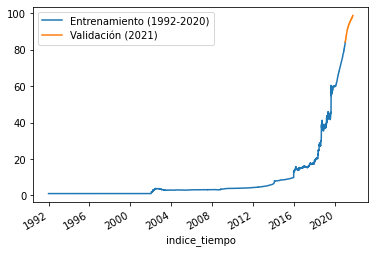

In [6]:
set_entrenamiento['dolar_estadounidense'].plot(legend=True)
set_validacion['dolar_estadounidense'].plot(legend=True)
plt.legend(['Entrenamiento (1992-2020)', 'Validación (2021)'])
plt.show()

Normalización del set de entrenamiento

In [9]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a partir de esos "time_step" datos). 

Se conformará de esta forma el set de entrenamiento

In [10]:
time_step = 30
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

In [11]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

Reshape X_train para que se ajuste al modelo en Keras

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Red LSTM

In [13]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 30

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [14]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=180)

Epoch 1/20
59/59 [==============================] - 2s 10ms/step - loss: 0.0016
Epoch 2/20
59/59 [==============================] - 1s 10ms/step - loss: 1.0724e-04
Epoch 3/20
59/59 [==============================] - 1s 10ms/step - loss: 8.9382e-05
Epoch 4/20
59/59 [==============================] - 1s 9ms/step - loss: 7.3475e-05
Epoch 5/20
59/59 [==============================] - 1s 9ms/step - loss: 6.3031e-05
Epoch 6/20
59/59 [==============================] - 1s 10ms/step - loss: 6.4731e-05
Epoch 7/20
59/59 [==============================] - 1s 10ms/step - loss: 4.9898e-05
Epoch 8/20
59/59 [==============================] - 1s 11ms/step - loss: 5.0122e-05
Epoch 9/20
59/59 [==============================] - 1s 10ms/step - loss: 4.5665e-05
Epoch 10/20
59/59 [==============================] - 1s 9ms/step - loss: 4.4539e-05
Epoch 11/20
59/59 [==============================] - 1s 10ms/step - loss: 4.1788e-05
Epoch 12/20
59/59 [==============================] - 1s 9ms/step - loss: 3.7241e-

Validación (predicción del valor del dólar)

In [15]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

C:\Users\lopez\miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [16]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [17]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

8/8 [==============================] - 0s 4ms/step


Graficar resultados

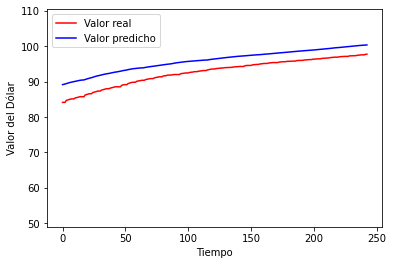

In [18]:
graficar_predicciones(set_validacion.values,prediccion)

In [34]:
modelo.save('lstm_pred_dolar.h5')